In [16]:
import os, math
from collections import defaultdict
import itertools
import sqlite3

from PIL import Image, ImageDraw
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy
import numpy as np
import cupy as cp
import pandas as pd

from utils import *
from hdc import *

In [17]:
config = Config('SQLITE3')
RNG = np.random.default_rng()

if cp.cuda.is_available():
    device_marker = cp.empty(1)
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    device_marker = np.empty(1)
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    
xp = cp.get_array_module(device_marker)
print(f'xp = {xp.__name__}')

train_db_con = sqlite3.connect(os.path.join(config.dataset_path, config.train_db_file_name))
test_db_con = sqlite3.connect(os.path.join(config.dataset_path, config.test_db_file_name))

xp = numpy


In [18]:
%time
df_train_images = pd.read_sql_query('SELECT * FROM images', con=train_db_con, index_col='image_id')
df_test_images = pd.read_sql_query('SELECT * FROM images', con=test_db_con, index_col='image_id')
df_train_images.shape, df_test_images.shape

CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 5.72 μs


((10000, 3), (2000, 3))

In [19]:
df_train_images.head()

,index,value,png
image_id,,,
27456,0,2,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
50770,1,3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
9353,2,4,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
50328,3,0,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...
18785,4,3,b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\...


In [20]:
df_first_encoding = pd.read_sql_query('SELECT * FROM image_encodings LIMIT 1', con=train_db_con)
assert len(df_first_encoding) > 0
IMAGE_ENCODING_DIMS = np.frombuffer(df_first_encoding.iloc[0]['data'], dtype='b').shape[0]
assert IMAGE_ENCODING_DIMS > 0
IMAGE_ENCODING_DIMS

4096

In [21]:
def matrix_to_image(m):
    m = m.ravel()
    sz = int(np.sqrt(m.shape[0]))
    assert sz * sz == m.shape[0]
    return Image.frombytes('L', size=(sz, sz), data=m.astype('b'))

In [22]:
def lay_grid(image, step):
    draw = ImageDraw.Draw(image)

    for c in range(step - 1, image.height, step):
        draw.line([0, c, image.width, c], fill=127)
        draw.line([c, 0, c, image.height], fill=127)

    return image


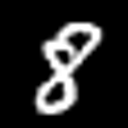
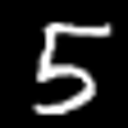
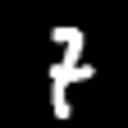
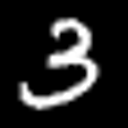
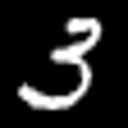
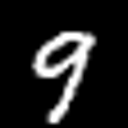
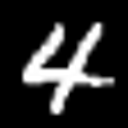
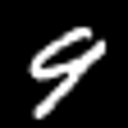
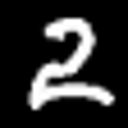
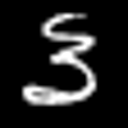
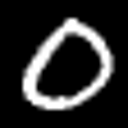
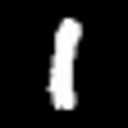
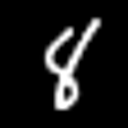
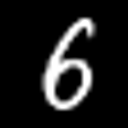
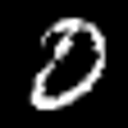
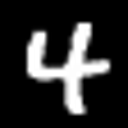

In [23]:
count = 8

def get_some_random_images_and_labels(df, count):
    image_ids = RNG.choice(df.index.unique(), count, replace=False)
    image_datas = df.loc[image_ids]['png']
    images = [Image.open(io.BytesIO(image_data)) for image_data in image_datas]
    labels = df.loc[image_ids]['value']
    return images, list(labels)

train_images, train_labels = get_some_random_images_and_labels(df_train_images, count)
test_images, test_labels = get_some_random_images_and_labels(df_test_images, count)

display_images_grid(train_images + test_images, captions=train_labels + test_labels, col_count=count)

In [24]:
#COS_SIM_THRESHOLD = 0.075
COS_SIM_THRESHOLD = 0.055
hdc = Hdc(10_000, np)

In [25]:
def generate_permutation_matrix(input_vector_dims):
    pm = np.zeros((input_vector_dims, input_vector_dims), dtype='b')
    row_indices = RNG.choice(pm.shape[0], pm.shape[0], replace=False)
    
    for row_index, column_index in zip(row_indices, range(pm.shape[1])):
        pm[row_index, column_index] = 1

    return pm

In [26]:
pm = generate_permutation_matrix(100)
assert np.array_equal((pm == 1).sum(axis=0), np.ones(pm.shape[0]))
assert np.array_equal((pm == 1).sum(axis=1), np.ones(pm.shape[0]))
rand_vec = RNG.integers(0, 2, pm.shape[0])
mutated_rand_vec = pm @ rand_vec
assert np.array_equal(pm.T @ mutated_rand_vec, rand_vec)
assert np.array_equal(np.unique_counts(rand_vec).counts, np.unique_counts(mutated_rand_vec).counts)

In [27]:
class CorticalColumn(object):
    def __init__(self, input_vector_dims, stride_width, strides_count):
        #self.input_vector_permutation2 = generate_permutation_matrix(input_vector_dims)
        self.stride_width = stride_width
        self.stride_hdvs = defaultdict(hdc)

        assert input_vector_dims >= stride_width
        total_strides = input_vector_dims // stride_width
        assert strides_count <= total_strides
        self.stride_indices = RNG.choice(total_strides, strides_count, replace=False)
        self.stride_indices *= stride_width
        assert np.all(np.unique_counts(self.stride_indices).counts == 1)

        #self.bundles = defaultdict(list)
        # self.bundles = dict()
        # self.bundle_to_image_ids = defaultdict(set)
        # self.bundles_norm = HdvArray(hdc.N, np)

        self.clusters = defaultdict(list) # cluster = collection of image bundles for particular class
        self.cluster_norms = HdvArray(hdc.N, np)
        self.cluster_to_image_ids = defaultdict(set) 

    def bundle_input_vectors(self, input_vectors):
        bundle = []

        for input_vector in input_vectors:
            input_vector_hdv = []
            
            for stride_index in self.stride_indices:
                stride = input_vector[stride_index:stride_index + self.stride_width]
    
                if np.all(stride == 0):
                    continue
                    
                stride_code = ''.join(map(str, stride.tolist()))
                stride_hdv = self.stride_hdvs[stride_code]
                stride_hdv = hdc.shift(stride_hdv, stride_index)
                input_vector_hdv.append(stride_hdv)
    
            if not input_vector_hdv:
                continue

            input_vector_hdv = hdc.bundle(input_vector_hdv)
            bundle.append(input_vector_hdv)

        if not bundle:
            return None

        return hdc.bundle(bundle) if len(bundle) > 1 else bundle[0]

In [28]:
stride_width = 16
COLUMN = CorticalColumn(IMAGE_ENCODING_DIMS, stride_width, IMAGE_ENCODING_DIMS // stride_width)

# v.1 TRAIN ON DRIFTS, INFER ON SINGLE IMAGE

In [102]:
stride_width = 16
COLUMN = CorticalColumn(IMAGE_ENCODING_DIMS, stride_width, IMAGE_ENCODING_DIMS // stride_width)
df_train_progress = pd.DataFrame(columns=['count', 'infers', 'correct_infers'])

trials = 30
count = 100

for trials in tqdm(range(trials)):
    # TRAIN STEP
    train_step_image_ids = RNG.choice(df_train_images.index.unique(), count, replace=False)

    for image_id in tqdm(train_step_image_ids, leave=False):
        image_value = df_train_images.loc[image_id]['value']
        df_image_encodings = pd.read_sql(f'SELECT data FROM image_encodings WHERE image_id=:image_id', params={'image_id': int(image_id)}, con=train_db_con)
        assert len(df_image_encodings) > 0
        image_encodings = list(map(lambda d: np.frombuffer(d, dtype='b'), df_image_encodings['data']))
        image_bundle = COLUMN.bundle_input_vectors(image_encodings)
        assert not image_bundle is None
        image_bundle_norm = hdc.normalize(image_bundle)
        cos_sims = COLUMN.cluster_norms.array @ image_bundle_norm
        cos_sims_indices = np.argwhere(cos_sims >= COS_SIM_THRESHOLD).reshape(-1)
        sorted_cos_sims_with_indices = sorted(zip(cos_sims[cos_sims_indices], cos_sims_indices), key=lambda x: -x[0]) # sort by cos sim desc

        # Debundle from ALL clusters which showed similarity but actually are not
        for _, index in sorted_cos_sims_with_indices:
            similar_cluster = COLUMN.clusters[index]
            similar_cluster_image_ids = COLUMN.cluster_to_image_ids[index]
            assert len(similar_cluster_image_ids) > 0
            similar_cluster_image_id = next(iter(similar_cluster_image_ids)) # pick any
            similar_cluster_image_value = df_train_images.loc[similar_cluster_image_id]['value']

            if similar_cluster_image_value != image_value:
                similar_cluster.append(hdc.complement(image_bundle))
                COLUMN.cluster_norms.array[index] = hdc.normalize(hdc.bundle(similar_cluster))

        # Bundle with MOST successive one
        for _, index in sorted_cos_sims_with_indices:
            similar_cluster = COLUMN.clusters[index]
            similar_cluster_image_ids = COLUMN.cluster_to_image_ids[index]
            assert len(similar_cluster_image_ids) > 0
            similar_cluster_image_id = next(iter(similar_cluster_image_ids)) # pick any
            similar_cluster_image_value = df_train_images.loc[similar_cluster_image_id]['value']

            if similar_cluster_image_value == image_value:
                if not image_id in similar_cluster_image_ids:
                    similar_cluster_image_ids.add(image_id)
                    similar_cluster.append(image_bundle)
                    COLUMN.cluster_norms.array[index] = hdc.normalize(hdc.bundle(similar_cluster))
                    
                break # there must be only one
        else:
            # Didn't find any matching cluster of HDVs to join -> create new one
            index = COLUMN.cluster_norms.lease()
            COLUMN.cluster_norms.array[index] = image_bundle_norm
            assert np.array_equal(COLUMN.cluster_norms.array[index], image_bundle_norm)
            COLUMN.clusters[index].append(image_bundle)
            COLUMN.cluster_to_image_ids[index].add(image_id)

    # CONSOLIDATE MEMORY
    before_len = COLUMN.cluster_norms.len()
    assert before_len == len(COLUMN.clusters)
    cluster_indices_to_release = []
    
    for cluster_index, image_ids in COLUMN.cluster_to_image_ids.items():
        if len(image_ids) <= 1:
            cluster_indices_to_release.append(cluster_index)

    for cluster_index_to_release in cluster_indices_to_release:
        del COLUMN.clusters[cluster_index_to_release]
        del COLUMN.cluster_to_image_ids[cluster_index_to_release]
        COLUMN.cluster_norms.release(cluster_index_to_release)

    after_len = COLUMN.cluster_norms.len()
    assert after_len == len(COLUMN.clusters)

    # INFER STEP
    inference_count = 0
    correct_inference_count = 0
    infer_step_image_ids = RNG.choice(df_train_images.index.unique(), count, replace=False)

    for image_id in tqdm(infer_step_image_ids, leave=False):
        image_value = df_train_images.loc[image_id]['value']
        df_image_encodings = pd.read_sql(f'SELECT data FROM image_encodings WHERE image_id=:image_id LIMIT 1', params={'image_id': int(image_id)}, con=train_db_con)
        assert len(df_image_encodings) == 1
        image_encoding = df_image_encodings.iloc[0]['data']
        image_encoding = np.frombuffer(image_encoding, dtype='b')
        image_bundle = COLUMN.bundle_input_vectors([image_encoding])
        assert not image_bundle is None
        image_bundle_norm = hdc.normalize(image_bundle)
        cos_sims = COLUMN.cluster_norms.array @ image_bundle_norm
        max_cos_sim_index = np.argmax(cos_sims)

        if cos_sims[max_cos_sim_index] <= COS_SIM_THRESHOLD:
            continue
            
        inference_count += 1

        similar_cluster_image_ids = COLUMN.cluster_to_image_ids[max_cos_sim_index]
        assert len(similar_cluster_image_ids) > 0
        similar_cluster_image_id = next(iter(similar_cluster_image_ids))
        similar_cluster_image_value = df_train_images.loc[similar_cluster_image_id]['value']
        
        is_correct_infer = similar_cluster_image_value == image_value
        correct_inference_count += int(is_correct_infer)
        
    df_train_progress.loc[len(df_train_progress)] = [count, inference_count, correct_inference_count]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [103]:
# Есть ли вложенность/пересечения в кластерах???
for i, image_ids_i in COLUMN.cluster_to_image_ids.items():
    for j, image_ids_j in COLUMN.cluster_to_image_ids.items():
        if i == j:
            continue

        if image_ids_i.issubset(image_ids_j):
            print(f'{i} is a subset of {j}')

        z = image_ids_i.intersection(image_ids_j)

        if z:
            print(f'{i} & {j} -> {z}')


0 & 33 -> {np.int64(35575)}
1 & 22 -> {np.int64(14427), np.int64(25596)}
22 & 1 -> {np.int64(14427), np.int64(25596)}
33 & 0 -> {np.int64(35575)}
33 & 36 -> {np.int64(28619)}
36 & 33 -> {np.int64(28619)}



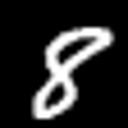
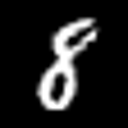
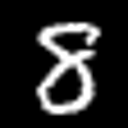
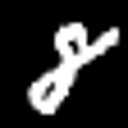
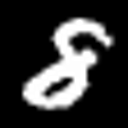
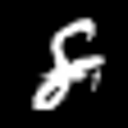
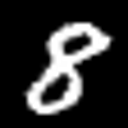
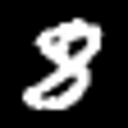
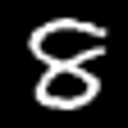
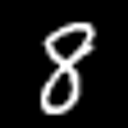
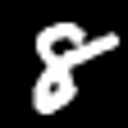
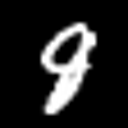
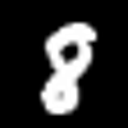
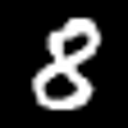
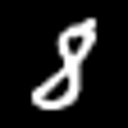
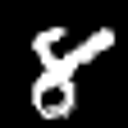
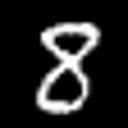
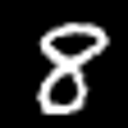
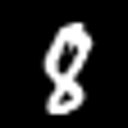
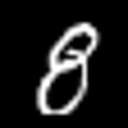
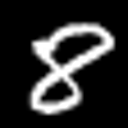
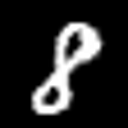
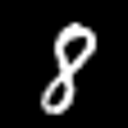
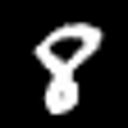
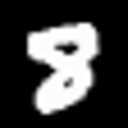
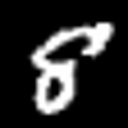
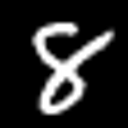
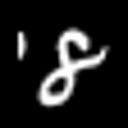
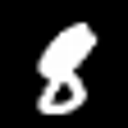
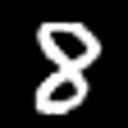
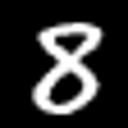
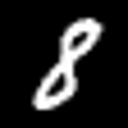
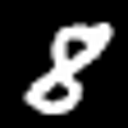
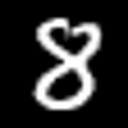
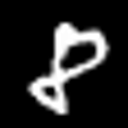
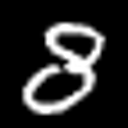
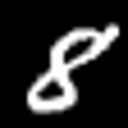
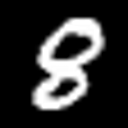
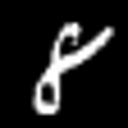
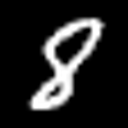
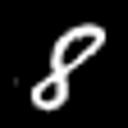
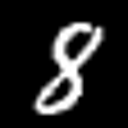
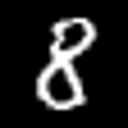
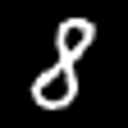
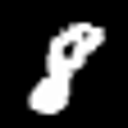
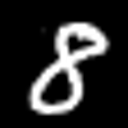
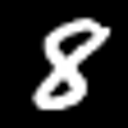
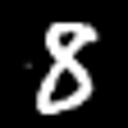
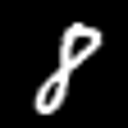
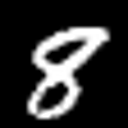
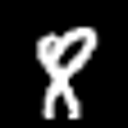
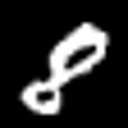
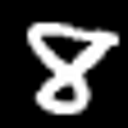
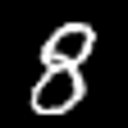
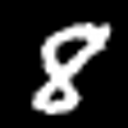
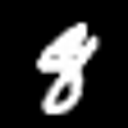
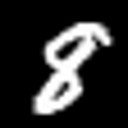
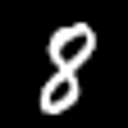
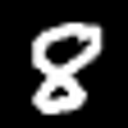
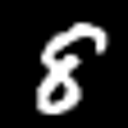
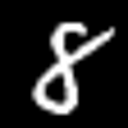
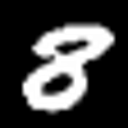
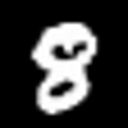
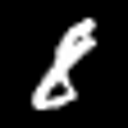
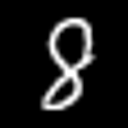
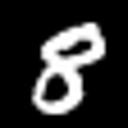
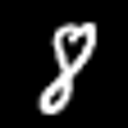
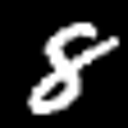
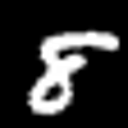
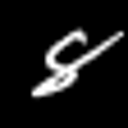
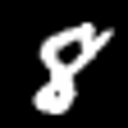
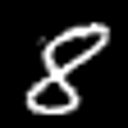
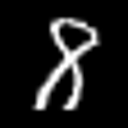
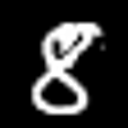
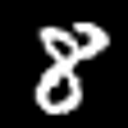
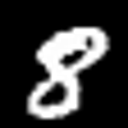
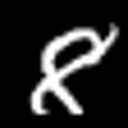
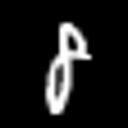
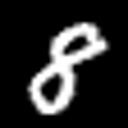
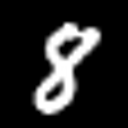
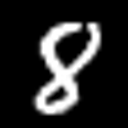
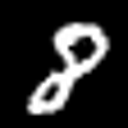
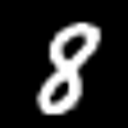
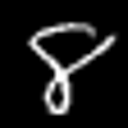
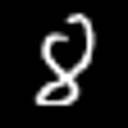
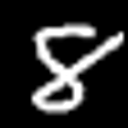
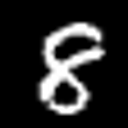
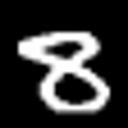
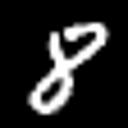
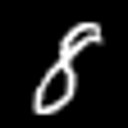
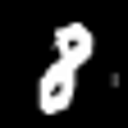
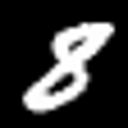
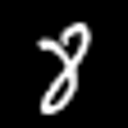
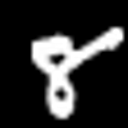
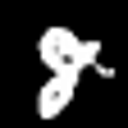
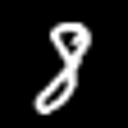
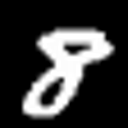
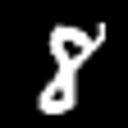
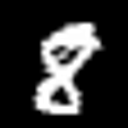
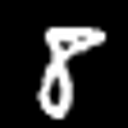
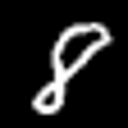
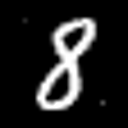
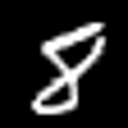
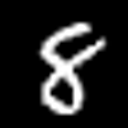
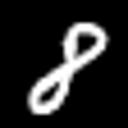
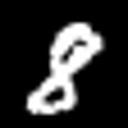
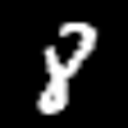
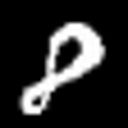
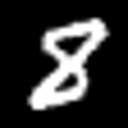
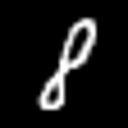
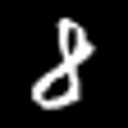
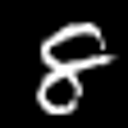
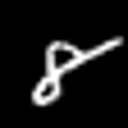
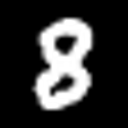
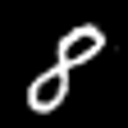
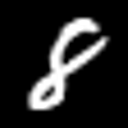

In [105]:
images = []
captions = []

if COLUMN.clusters.keys():
    random_cluster_i = RNG.choice(list(COLUMN.clusters.keys()))
    image_ids = COLUMN.cluster_to_image_ids[random_cluster_i]
    df_i = df_train_images.loc[list(image_ids)]
    image_datas = df_i['png']
    images = [Image.open(io.BytesIO(image_data)) for image_data in image_datas]
    captions = list(map(lambda p: f'clust={random_cluster_i}, #{p[0]}, val={p[1]}', zip(df_i.index, df_i['value'])))
    
display_images_grid(images, captions=captions, col_count=8)

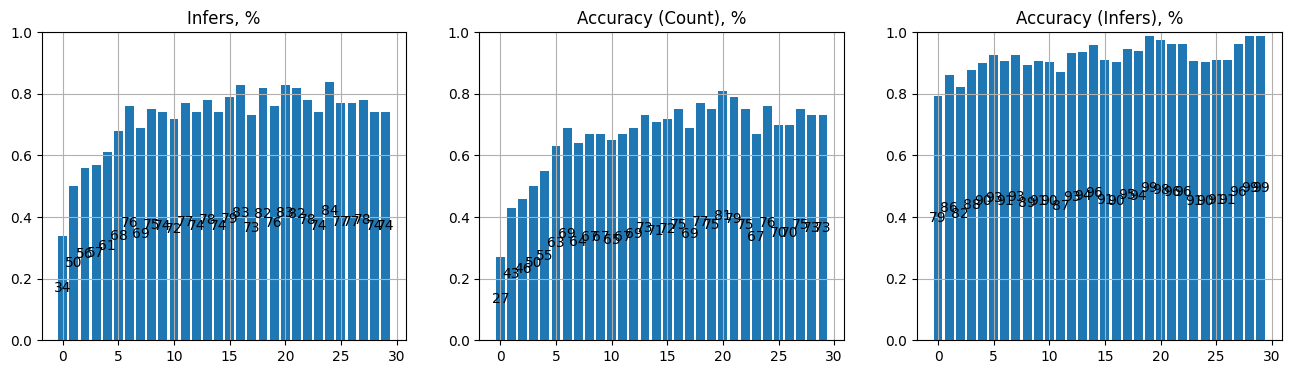

,count,infers,correct_infers,infer_ratio,accuracy_count,accuracy_infers
0,100,34,27,0.34,0.27,0.794118
1,100,50,43,0.50,0.43,0.860000
2,100,56,46,0.56,0.46,0.821429
3,100,57,50,0.57,0.50,0.877193
4,100,61,55,0.61,0.55,0.901639
5,100,68,63,0.68,0.63,0.926471
6,100,76,69,0.76,0.69,0.907895
7,100,69,64,0.69,0.64,0.927536
8,100,75,67,0.75,0.67,0.893333
9,100,74,67,0.74,0.67,0.905405


In [106]:
df_train_progress2 = df_train_progress.copy()
df_train_progress2['infer_ratio'] = df_train_progress2['infers'] / df_train_progress2['count']
df_train_progress2['accuracy_count'] = df_train_progress2['correct_infers'] / df_train_progress2['count']
df_train_progress2['accuracy_infers'] = df_train_progress2['correct_infers'] / df_train_progress2['infers']

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
b = plt.bar(list(df_train_progress2.index), list(df_train_progress2['infer_ratio']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_train_progress2['infer_ratio']), label_type='center')
plt.ylim(0, 1)
plt.title('Infers, %')
plt.grid()

plt.subplot(1, 3, 2)
b = plt.bar(list(df_train_progress2.index), list(df_train_progress2['accuracy_count']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_train_progress2['accuracy_count']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Count), %')
plt.grid()

plt.subplot(1, 3, 3)
b = plt.bar(list(df_train_progress2.index), list(df_train_progress2['accuracy_infers']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_train_progress2['accuracy_infers']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Infers), %')
plt.grid()

plt.show()
df_train_progress2

# v.1a TRAIN ON DRIFTS, INFER ON DRIFTS

In [107]:
stride_width = 16
COLUMN = CorticalColumn(IMAGE_ENCODING_DIMS, stride_width, IMAGE_ENCODING_DIMS // stride_width)
df_train_progress = pd.DataFrame(columns=['count', 'infers', 'correct_infers'])

trials = 30
count = 100

for trials in tqdm(range(trials)):
    # TRAIN STEP
    train_step_image_ids = RNG.choice(df_train_images.index.unique(), count, replace=False)

    for image_id in tqdm(train_step_image_ids, leave=False):
        image_value = df_train_images.loc[image_id]['value']
        df_image_encodings = pd.read_sql(f'SELECT data FROM image_encodings WHERE image_id=:image_id', params={'image_id': int(image_id)}, con=train_db_con)
        assert len(df_image_encodings) > 0
        image_encodings = list(map(lambda d: np.frombuffer(d, dtype='b'), df_image_encodings['data']))
        image_bundle = COLUMN.bundle_input_vectors(image_encodings)
        assert not image_bundle is None
        image_bundle_norm = hdc.normalize(image_bundle)
        cos_sims = COLUMN.cluster_norms.array @ image_bundle_norm
        cos_sims_indices = np.argwhere(cos_sims >= COS_SIM_THRESHOLD).reshape(-1)
        sorted_cos_sims_with_indices = sorted(zip(cos_sims[cos_sims_indices], cos_sims_indices), key=lambda x: -x[0]) # sort by cos sim desc

        # Debundle from ALL clusters which showed similarity but actually are not
        for _, index in sorted_cos_sims_with_indices:
            similar_cluster = COLUMN.clusters[index]
            similar_cluster_image_ids = COLUMN.cluster_to_image_ids[index]
            assert len(similar_cluster_image_ids) > 0
            similar_cluster_image_id = next(iter(similar_cluster_image_ids)) # pick any
            similar_cluster_image_value = df_train_images.loc[similar_cluster_image_id]['value']

            if similar_cluster_image_value != image_value:
                similar_cluster.append(hdc.complement(image_bundle))
                COLUMN.cluster_norms.array[index] = hdc.normalize(hdc.bundle(similar_cluster))

        # Bundle with MOST successive one
        for _, index in sorted_cos_sims_with_indices:
            similar_cluster = COLUMN.clusters[index]
            similar_cluster_image_ids = COLUMN.cluster_to_image_ids[index]
            assert len(similar_cluster_image_ids) > 0
            similar_cluster_image_id = next(iter(similar_cluster_image_ids)) # pick any
            similar_cluster_image_value = df_train_images.loc[similar_cluster_image_id]['value']

            if similar_cluster_image_value == image_value:
                if not image_id in similar_cluster_image_ids:
                    similar_cluster_image_ids.add(image_id)
                    similar_cluster.append(image_bundle)
                    COLUMN.cluster_norms.array[index] = hdc.normalize(hdc.bundle(similar_cluster))
                    
                break # there must be only one
        else:
            # Didn't find any matching cluster of HDVs to join -> create new one
            index = COLUMN.cluster_norms.lease()
            COLUMN.cluster_norms.array[index] = image_bundle_norm
            assert np.array_equal(COLUMN.cluster_norms.array[index], image_bundle_norm)
            COLUMN.clusters[index].append(image_bundle)
            COLUMN.cluster_to_image_ids[index].add(image_id)

    # CONSOLIDATE MEMORY
    before_len = COLUMN.cluster_norms.len()
    assert before_len == len(COLUMN.clusters)
    cluster_indices_to_release = []
    
    for cluster_index, image_ids in COLUMN.cluster_to_image_ids.items():
        if len(image_ids) <= 1:
            cluster_indices_to_release.append(cluster_index)

    for cluster_index_to_release in cluster_indices_to_release:
        del COLUMN.clusters[cluster_index_to_release]
        del COLUMN.cluster_to_image_ids[cluster_index_to_release]
        COLUMN.cluster_norms.release(cluster_index_to_release)

    after_len = COLUMN.cluster_norms.len()
    assert after_len == len(COLUMN.clusters)

    # INFER STEP
    inference_count = 0
    correct_inference_count = 0
    infer_step_image_ids = RNG.choice(df_train_images.index.unique(), count, replace=False)

    for image_id in tqdm(infer_step_image_ids, leave=False):
        image_value = df_train_images.loc[image_id]['value']
        df_image_encodings = pd.read_sql(f'SELECT data FROM image_encodings WHERE image_id=:image_id', params={'image_id': int(image_id)}, con=train_db_con)
        assert len(df_image_encodings) > 0
        image_encodings = list(map(lambda d: np.frombuffer(d, dtype='b'), df_image_encodings['data']))

        for image_encoding in image_encodings:
            image_bundle = COLUMN.bundle_input_vectors([image_encoding])
            assert not image_bundle is None
            image_bundle_norm = hdc.normalize(image_bundle)
            cos_sims = COLUMN.cluster_norms.array @ image_bundle_norm
            max_cos_sim_index = np.argmax(cos_sims)
    
            if cos_sims[max_cos_sim_index] <= COS_SIM_THRESHOLD:
                continue
                
            inference_count += 1
    
            similar_cluster_image_ids = COLUMN.cluster_to_image_ids[max_cos_sim_index]
            assert len(similar_cluster_image_ids) > 0
            similar_cluster_image_id = next(iter(similar_cluster_image_ids))
            similar_cluster_image_value = df_train_images.loc[similar_cluster_image_id]['value']
            
            is_correct_infer = similar_cluster_image_value == image_value
            correct_inference_count += int(is_correct_infer)
            break
        
    df_train_progress.loc[len(df_train_progress)] = [count, inference_count, correct_inference_count]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [109]:
len(COLUMN.clusters)

42

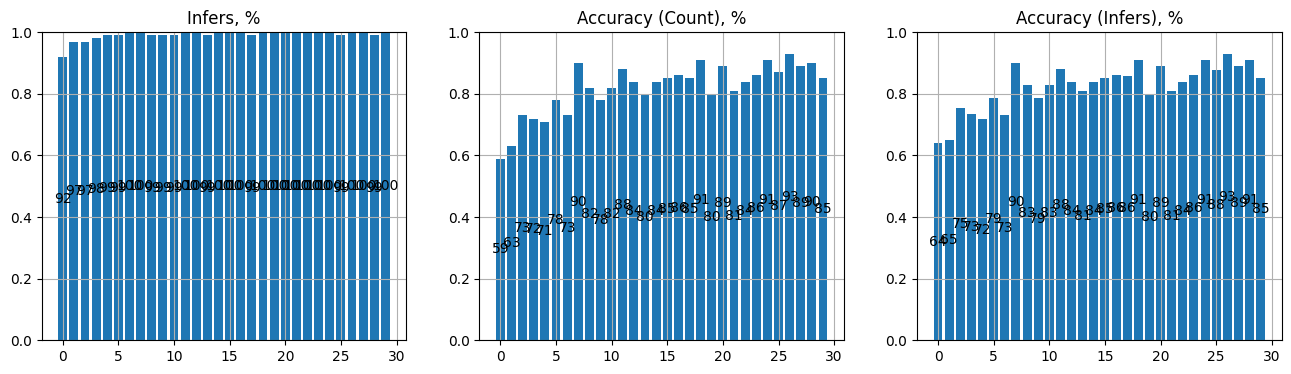

,count,infers,correct_infers,infer_ratio,accuracy_count,accuracy_infers
0,100,92,59,0.92,0.59,0.641304
1,100,97,63,0.97,0.63,0.649485
2,100,97,73,0.97,0.73,0.752577
3,100,98,72,0.98,0.72,0.734694
4,100,99,71,0.99,0.71,0.717172
5,100,99,78,0.99,0.78,0.787879
6,100,100,73,1.00,0.73,0.730000
7,100,100,90,1.00,0.90,0.900000
8,100,99,82,0.99,0.82,0.828283
9,100,99,78,0.99,0.78,0.787879


In [108]:
df_train_progress2 = df_train_progress.copy()
df_train_progress2['infer_ratio'] = df_train_progress2['infers'] / df_train_progress2['count']
df_train_progress2['accuracy_count'] = df_train_progress2['correct_infers'] / df_train_progress2['count']
df_train_progress2['accuracy_infers'] = df_train_progress2['correct_infers'] / df_train_progress2['infers']

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
b = plt.bar(list(df_train_progress2.index), list(df_train_progress2['infer_ratio']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_train_progress2['infer_ratio']), label_type='center')
plt.ylim(0, 1)
plt.title('Infers, %')
plt.grid()

plt.subplot(1, 3, 2)
b = plt.bar(list(df_train_progress2.index), list(df_train_progress2['accuracy_count']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_train_progress2['accuracy_count']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Count), %')
plt.grid()

plt.subplot(1, 3, 3)
b = plt.bar(list(df_train_progress2.index), list(df_train_progress2['accuracy_infers']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_train_progress2['accuracy_infers']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Infers), %')
plt.grid()

plt.show()
df_train_progress2

# v.1a TRAIN ON DRIFTS, INFER ON DRIFTS + RANDOM RELEASE BY EXP. DISTRO

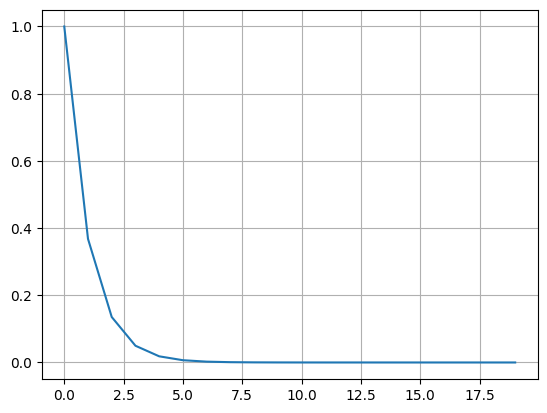

[np.float64(1.0),
 np.float64(0.36787944117144233),
 np.float64(0.1353352832366127),
 np.float64(0.049787068367863944),
 np.float64(0.01831563888873418),
 np.float64(0.006737946999085467),
 np.float64(0.0024787521766663585),
 np.float64(0.0009118819655545162),
 np.float64(0.00033546262790251185),
 np.float64(0.00012340980408667956),
 np.float64(4.5399929762484854e-05),
 np.float64(1.670170079024566e-05),
 np.float64(6.14421235332821e-06),
 np.float64(2.2603294069810542e-06),
 np.float64(8.315287191035679e-07),
 np.float64(3.059023205018258e-07),
 np.float64(1.1253517471925912e-07),
 np.float64(4.139937718785167e-08),
 np.float64(1.522997974471263e-08),
 np.float64(5.602796437537268e-09)]

In [115]:
l = 1
xs = range(20)
ys = []
    
for x in range(len(xs)):
    # x = x / len(xs)
    y = l * np.exp(-l * x)
    ys.append(y)

plt.plot(xs, ys)
plt.grid()
plt.show()
ys

In [157]:
stride_width = 16
COLUMN = CorticalColumn(IMAGE_ENCODING_DIMS, stride_width, IMAGE_ENCODING_DIMS // stride_width)
df_train_progress = pd.DataFrame(columns=['count', 'infers', 'correct_infers'])
df_conso_progress = pd.DataFrame(columns=['trial', 'stage', 'cluster_id', 'len'])

trials = 30
count = 100

for trial in tqdm(range(trials)):
    # TRAIN STEP
    train_step_image_ids = RNG.choice(df_train_images.index.unique(), count, replace=False)

    for image_id in tqdm(train_step_image_ids, leave=False):
        image_value = df_train_images.loc[image_id]['value']
        df_image_encodings = pd.read_sql(f'SELECT data FROM image_encodings WHERE image_id=:image_id', params={'image_id': int(image_id)}, con=train_db_con)
        assert len(df_image_encodings) > 0
        image_encodings = list(map(lambda d: np.frombuffer(d, dtype='b'), df_image_encodings['data']))
        image_bundle = COLUMN.bundle_input_vectors(image_encodings)
        assert not image_bundle is None
        image_bundle_norm = hdc.normalize(image_bundle)
        cos_sims = COLUMN.cluster_norms.array @ image_bundle_norm
        cos_sims_indices = np.argwhere(cos_sims >= COS_SIM_THRESHOLD).reshape(-1)
        sorted_cos_sims_with_indices = sorted(zip(cos_sims[cos_sims_indices], cos_sims_indices), key=lambda x: -x[0]) # sort by cos sim desc

        # Debundle from ALL clusters which showed similarity but actually are not
        for _, index in sorted_cos_sims_with_indices:
            similar_cluster = COLUMN.clusters[index]
            similar_cluster_image_ids = COLUMN.cluster_to_image_ids[index]
            assert len(similar_cluster_image_ids) > 0
            similar_cluster_image_id = next(iter(similar_cluster_image_ids)) # pick any
            similar_cluster_image_value = df_train_images.loc[similar_cluster_image_id]['value']

            if similar_cluster_image_value != image_value:
                similar_cluster.append(hdc.complement(image_bundle))
                COLUMN.cluster_norms.array[index] = hdc.normalize(hdc.bundle(similar_cluster))

        # Bundle with MOST successive one
        for _, index in sorted_cos_sims_with_indices:
            similar_cluster = COLUMN.clusters[index]
            similar_cluster_image_ids = COLUMN.cluster_to_image_ids[index]
            assert len(similar_cluster_image_ids) > 0
            similar_cluster_image_id = next(iter(similar_cluster_image_ids)) # pick any
            similar_cluster_image_value = df_train_images.loc[similar_cluster_image_id]['value']

            if similar_cluster_image_value == image_value:
                if not image_id in similar_cluster_image_ids:
                    similar_cluster_image_ids.add(image_id)
                    similar_cluster.append(image_bundle)
                    COLUMN.cluster_norms.array[index] = hdc.normalize(hdc.bundle(similar_cluster))
                    
                break # there must be only one
        else:
            # Didn't find any matching cluster of HDVs to join -> create new one
            index = COLUMN.cluster_norms.lease()
            COLUMN.cluster_norms.array[index] = image_bundle_norm
            assert np.array_equal(COLUMN.cluster_norms.array[index], image_bundle_norm)
            COLUMN.clusters[index].append(image_bundle)
            COLUMN.cluster_to_image_ids[index].add(image_id)

    # CONSOLIDATE MEMORY
    for cluster_index, image_ids in COLUMN.cluster_to_image_ids.items():
        df_conso_progress.loc[len(df_conso_progress)] = [trial, 'before', cluster_index, len(image_ids)]
    
    before_len = COLUMN.cluster_norms.len()
    assert before_len == len(COLUMN.clusters)
    cluster_indices_to_release = []
    
    for cluster_index, image_ids in COLUMN.cluster_to_image_ids.items():
        exp_distro_level = l * np.exp(-l * len(image_ids))
        rand_level = RNG.random()
        do_release = rand_level < exp_distro_level
        
        if do_release:
            cluster_indices_to_release.append(cluster_index)

    for cluster_index_to_release in cluster_indices_to_release:
        del COLUMN.clusters[cluster_index_to_release]
        del COLUMN.cluster_to_image_ids[cluster_index_to_release]
        COLUMN.cluster_norms.release(cluster_index_to_release)

    after_len = COLUMN.cluster_norms.len()
    assert after_len == len(COLUMN.clusters)
    
    for cluster_index, image_ids in COLUMN.cluster_to_image_ids.items():
        df_conso_progress.loc[len(df_conso_progress)] = [trial, 'after', cluster_index, len(image_ids)]

    # INFER STEP
    inference_count = 0
    correct_inference_count = 0
    infer_step_image_ids = RNG.choice(df_train_images.index.unique(), count, replace=False)

    for image_id in tqdm(infer_step_image_ids, leave=False):
        image_value = df_train_images.loc[image_id]['value']
        df_image_encodings = pd.read_sql(f'SELECT data FROM image_encodings WHERE image_id=:image_id', params={'image_id': int(image_id)}, con=train_db_con)
        assert len(df_image_encodings) > 0
        image_encodings = list(map(lambda d: np.frombuffer(d, dtype='b'), df_image_encodings['data']))

        for image_encoding in image_encodings:
            image_bundle = COLUMN.bundle_input_vectors([image_encoding])
            assert not image_bundle is None
            image_bundle_norm = hdc.normalize(image_bundle)
            cos_sims = COLUMN.cluster_norms.array @ image_bundle_norm
            max_cos_sim_index = np.argmax(cos_sims)
    
            if cos_sims[max_cos_sim_index] <= COS_SIM_THRESHOLD:
                continue
                
            inference_count += 1
    
            similar_cluster_image_ids = COLUMN.cluster_to_image_ids[max_cos_sim_index]
            assert len(similar_cluster_image_ids) > 0
            similar_cluster_image_id = next(iter(similar_cluster_image_ids))
            similar_cluster_image_value = df_train_images.loc[similar_cluster_image_id]['value']
            
            is_correct_infer = similar_cluster_image_value == image_value
            correct_inference_count += int(is_correct_infer)
            break
        
    df_train_progress.loc[len(df_train_progress)] = [count, inference_count, correct_inference_count]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

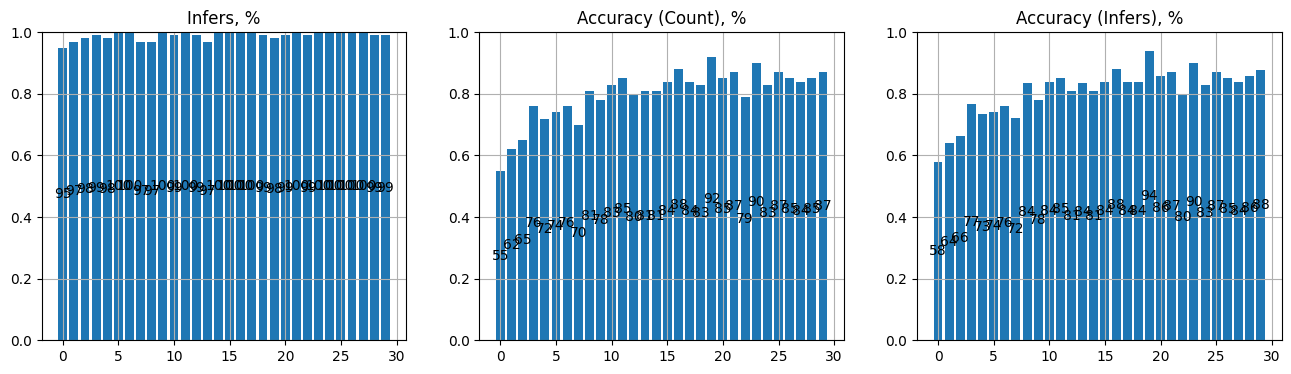

,count,infers,correct_infers,infer_ratio,accuracy_count,accuracy_infers
0,100,95,55,0.95,0.55,0.578947
1,100,97,62,0.97,0.62,0.639175
2,100,98,65,0.98,0.65,0.663265
3,100,99,76,0.99,0.76,0.767677
4,100,98,72,0.98,0.72,0.734694
5,100,100,74,1.00,0.74,0.740000
6,100,100,76,1.00,0.76,0.760000
7,100,97,70,0.97,0.70,0.721649
8,100,97,81,0.97,0.81,0.835052
9,100,100,78,1.00,0.78,0.780000


In [158]:
df_train_progress2 = df_train_progress.copy()
df_train_progress2['infer_ratio'] = df_train_progress2['infers'] / df_train_progress2['count']
df_train_progress2['accuracy_count'] = df_train_progress2['correct_infers'] / df_train_progress2['count']
df_train_progress2['accuracy_infers'] = df_train_progress2['correct_infers'] / df_train_progress2['infers']

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
b = plt.bar(list(df_train_progress2.index), list(df_train_progress2['infer_ratio']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_train_progress2['infer_ratio']), label_type='center')
plt.ylim(0, 1)
plt.title('Infers, %')
plt.grid()

plt.subplot(1, 3, 2)
b = plt.bar(list(df_train_progress2.index), list(df_train_progress2['accuracy_count']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_train_progress2['accuracy_count']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Count), %')
plt.grid()

plt.subplot(1, 3, 3)
b = plt.bar(list(df_train_progress2.index), list(df_train_progress2['accuracy_infers']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_train_progress2['accuracy_infers']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Infers), %')
plt.grid()

plt.show()
df_train_progress2

In [169]:
pd.set_option('display.max_rows', 500)
last_trial = df_conso_progress['trial'].max()
df_conso_progress[(df_conso_progress['trial'] == last_trial) &  (df_conso_progress['stage'] == 'after')].sort_values(by='len', ascending=False)

,trial,stage,cluster_id,len
2473,29,after,8,246
2471,29,after,3,241
2483,29,after,40,231
2481,29,after,34,222
2482,29,after,36,207
2485,29,after,50,195
2477,29,after,25,187
2475,29,after,20,185
2474,29,after,11,163
2472,29,after,5,152


# v.2 TRAIN ON SINGLE IMAGE, INFER ON DRIFTS

In [32]:
stride_width = 16
COLUMN = CorticalColumn(IMAGE_ENCODING_DIMS, stride_width, IMAGE_ENCODING_DIMS // stride_width)
df_train_progress = pd.DataFrame(columns=['count', 'infers', 'correct_infers'])

trials = 10
count = 100

for trials in tqdm(range(trials)):
    # TRAIN STEP
    train_step_image_ids = RNG.choice(df_train_images.index.unique(), count, replace=False)

    for image_id in tqdm(train_step_image_ids, leave=False):
        image_value = df_train_images.loc[image_id]['value']
        df_image_encodings = pd.read_sql(f'SELECT data FROM image_encodings WHERE image_id=:image_id LIMIT 1', params={'image_id': int(image_id)}, con=train_db_con)
        assert len(df_image_encodings) == 1
        image_encoding = df_image_encodings.iloc[0]['data']
        image_encoding = np.frombuffer(image_encoding, dtype='b')
        image_bundle = COLUMN.bundle_input_vectors([image_encoding])
        assert not image_bundle is None
        image_bundle_norm = hdc.normalize(image_bundle)
        cos_sims = COLUMN.cluster_norms.array @ image_bundle_norm
        cos_sims_indices = np.argwhere(cos_sims >= COS_SIM_THRESHOLD).reshape(-1)
        sorted_cos_sims_with_indices = sorted(zip(cos_sims[cos_sims_indices], cos_sims_indices), key=lambda x: -x[0]) # sort by cos sim desc

        # Debundle from ALL clusters which showed similarity but actually are not
        for _, index in sorted_cos_sims_with_indices:
            similar_cluster = COLUMN.clusters[index]
            similar_cluster_image_ids = COLUMN.cluster_to_image_ids[index]
            assert len(similar_cluster_image_ids) > 0
            similar_cluster_image_id = next(iter(similar_cluster_image_ids)) # pick any
            similar_cluster_image_value = df_train_images.loc[similar_cluster_image_id]['value']

            if similar_cluster_image_value != image_value:
                similar_cluster.append(hdc.complement(image_bundle))
                COLUMN.cluster_norms.array[index] = hdc.normalize(hdc.bundle(similar_cluster))

        # Bundle with MOST successive one
        for _, index in sorted_cos_sims_with_indices:
            similar_cluster = COLUMN.clusters[index]
            similar_cluster_image_ids = COLUMN.cluster_to_image_ids[index]
            assert len(similar_cluster_image_ids) > 0
            similar_cluster_image_id = next(iter(similar_cluster_image_ids)) # pick any
            similar_cluster_image_value = df_train_images.loc[similar_cluster_image_id]['value']

            if similar_cluster_image_value == image_value:
                if not image_id in similar_cluster_image_ids:
                    similar_cluster_image_ids.add(image_id)
                    similar_cluster.append(image_bundle)
                    COLUMN.cluster_norms.array[index] = hdc.normalize(hdc.bundle(similar_cluster))
                    
                break # there must be only one
        else:
            # Didn't find any matching cluster of HDVs to join -> create new one
            index = COLUMN.cluster_norms.lease()
            COLUMN.cluster_norms.array[index] = image_bundle_norm
            assert np.array_equal(COLUMN.cluster_norms.array[index], image_bundle_norm)
            COLUMN.clusters[index].append(image_bundle)
            COLUMN.cluster_to_image_ids[index].add(image_id)

    # CONSOLIDATE MEMORY
    before_len = COLUMN.cluster_norms.len()
    assert before_len == len(COLUMN.clusters)
    cluster_indices_to_release = []
    
    for cluster_index, image_ids in COLUMN.cluster_to_image_ids.items():
        if len(image_ids) <= 1:
            cluster_indices_to_release.append(cluster_index)

    for cluster_index_to_release in cluster_indices_to_release:
        del COLUMN.clusters[cluster_index_to_release]
        del COLUMN.cluster_to_image_ids[cluster_index_to_release]
        COLUMN.cluster_norms.release(cluster_index_to_release)

    after_len = COLUMN.cluster_norms.len()
    assert after_len == len(COLUMN.clusters)

    # INFER STEP
    inference_count = 0
    correct_inference_count = 0
    infer_step_image_ids = RNG.choice(df_train_images.index.unique(), count, replace=False)

    for image_id in tqdm(infer_step_image_ids, leave=False):
        image_value = df_train_images.loc[image_id]['value']
        df_image_encodings = pd.read_sql(f'SELECT data FROM image_encodings WHERE image_id=:image_id', params={'image_id': int(image_id)}, con=train_db_con)
        assert len(df_image_encodings) > 0
        image_encodings = list(map(lambda d: np.frombuffer(d, dtype='b'), df_image_encodings['data']))

        for image_encoding in image_encodings:
            image_bundle = COLUMN.bundle_input_vectors([image_encoding])
            assert not image_bundle is None
            image_bundle_norm = hdc.normalize(image_bundle)
            cos_sims = COLUMN.cluster_norms.array @ image_bundle_norm
            max_cos_sim_index = np.argmax(cos_sims)
    
            if cos_sims[max_cos_sim_index] <= COS_SIM_THRESHOLD:
                continue
                
            inference_count += 1
    
            similar_cluster_image_ids = COLUMN.cluster_to_image_ids[max_cos_sim_index]
            assert len(similar_cluster_image_ids) > 0
            similar_cluster_image_id = next(iter(similar_cluster_image_ids))
            similar_cluster_image_value = df_train_images.loc[similar_cluster_image_id]['value']
            
            is_correct_infer = similar_cluster_image_value == image_value
            correct_inference_count += int(is_correct_infer)
            break
        
    df_train_progress.loc[len(df_train_progress)] = [count, inference_count, correct_inference_count]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

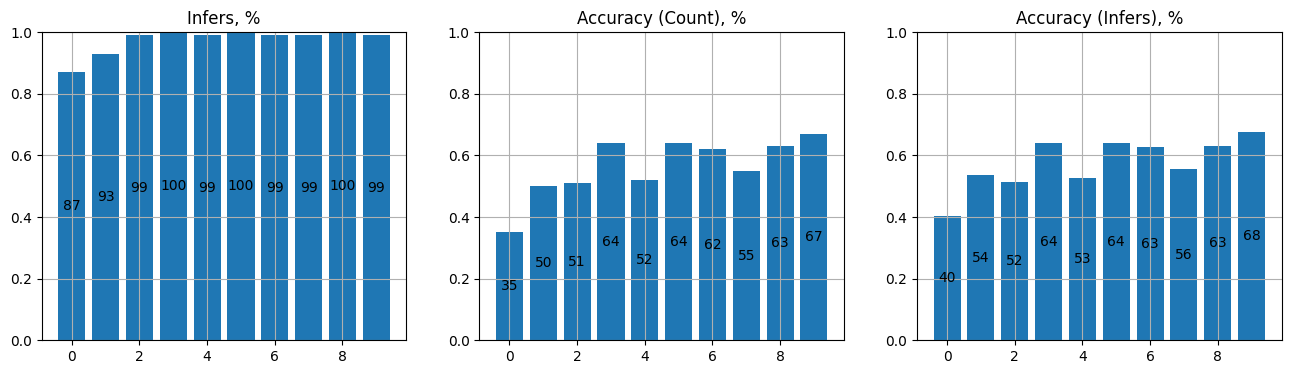

,count,infers,correct_infers,infer_ratio,accuracy_count,accuracy_infers
0,100,87,35,0.87,0.35,0.402299
1,100,93,50,0.93,0.50,0.537634
2,100,99,51,0.99,0.51,0.515152
3,100,100,64,1.00,0.64,0.640000
4,100,99,52,0.99,0.52,0.525253
5,100,100,64,1.00,0.64,0.640000
6,100,99,62,0.99,0.62,0.626263
7,100,99,55,0.99,0.55,0.555556
8,100,100,63,1.00,0.63,0.630000
9,100,99,67,0.99,0.67,0.676768


In [33]:
df_train_progress2 = df_train_progress.copy()
df_train_progress2['infer_ratio'] = df_train_progress2['infers'] / df_train_progress2['count']
df_train_progress2['accuracy_count'] = df_train_progress2['correct_infers'] / df_train_progress2['count']
df_train_progress2['accuracy_infers'] = df_train_progress2['correct_infers'] / df_train_progress2['infers']

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
b = plt.bar(list(df_train_progress2.index), list(df_train_progress2['infer_ratio']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_train_progress2['infer_ratio']), label_type='center')
plt.ylim(0, 1)
plt.title('Infers, %')
plt.grid()

plt.subplot(1, 3, 2)
b = plt.bar(list(df_train_progress2.index), list(df_train_progress2['accuracy_count']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_train_progress2['accuracy_count']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Count), %')
plt.grid()

plt.subplot(1, 3, 3)
b = plt.bar(list(df_train_progress2.index), list(df_train_progress2['accuracy_infers']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_train_progress2['accuracy_infers']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Infers), %')
plt.grid()

plt.show()
df_train_progress2